# *Benchmarking local computation in Spark*

An excellent feature of Spark is that it runs locally with minimal setup. This is incredibly useful for debugging, but can be surprisingly slow for *real* local computation, due to its enumlating certain aspects of the distributed codepath. Although local computation is not Spark's intended use case, real-world workflows often involve working with both large and medium sized data sets in the same notebook, and we want to maintain high performance without switching frameworks. This notebook serves to document these differences.

*Notes*: I'm using RDDs, not Spark's DataFrames, it's possible that performance would be improved for DataFrames, this would be good to try. A related point is that some of this difference could be Python specific, so it would be worth trying the same thing in Scala. Finally, it's worth rerunning with different values of *n* and *k*. In my own testing, I've found that the difference may scale by their ratio, it's dramatic when *n/k=10* and less dramatic when *n/k=100*.

## Setup

Import our packages

In [1]:
import timeit
from numpy import random, add, arange, fix, round, maximum, ceil, array, sum, percentile
from pandas import DataFrame

Setup plotting

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

Define a class for storing an RDD and running some benchmarks (best of 3 loops each with 3 reps) 

In [3]:
class Benchmark(object):
    
    def __init__(self, rdd):
        self.rdd = rdd
        
    def run(self, name):
        t = timeit.Timer(lambda: funcs[name](self.rdd))
        r = min([t.timeit(3)/3.0 * 1000 for _ in range(3)])
        return r

Define a dictionary of RDD operations

In [4]:
funcs = {}
funcs['sum'] = lambda rdd: rdd.values().reduce(add)
funcs['max'] = lambda rdd: rdd.values().reduce(maximum)
funcs['filter'] = lambda rdd: rdd.filter(lambda (k, v): k > 50).count()
funcs['map'] = lambda rdd: rdd.mapValues(lambda x: x.sum()).count()
funcs['collect'] = lambda rdd: rdd.values().collect()
funcs['reduceByKey'] = lambda rdd: rdd.reduceByKey(add).count()
funcs['groupByKey'] = lambda rdd: rdd.groupByKey().count()

## "Distributed" mode

Here we compute times for an RDD defined through `sc.parallelize`. It's a collection of records, each a one-dimensional numpy array.

In [5]:
n = 10000
k = 1000
vals = random.rand(n,k)
keys = ceil(random.rand(n) * 100)

We force a cache, and use only 1 slice. For most operation, parallelizing in local mode does not seem to improve times, and may even make things worse, but it's worth experimenting with in different environments.

In [6]:
rdd = sc.parallelize(zip(keys, vals), numSlices=1)
rdd.cache()
rdd.count()
t = Benchmark(rdd)

Run a simple benchmark using the timit magic

In [7]:
%timeit -n 3 rdd.values().reduce(add)

3 loops, best of 3: 427 ms per loop


Use our `Benchmark` class to do the same thing (confirm a similar answer)

In [8]:
t.run('sum')

364.14901415507

Now collect times for all functions

In [9]:
distributed = [t.run(k) for k in funcs.keys()]

In [10]:
DataFrame(distributed, index=funcs.keys(), columns=["time"])

,time
map,368.661960
reduceByKey,382.832050
max,365.530729
sum,359.167337
groupByKey,1343.993346
filter,358.441671
collect,1658.901691


## "Local" mode

Now we'll try a simple trick. In Thunder we've prototyped a `LocalRDD` (view on [GitHub](https://github.com/thunder-project/thunder/blob/local-rdd/python/thunder/rdds/local.py)) which is a rather dumb object that  replicates much of the RDD API but implemented through operations on locally stored lists, mainly using for comprehensions and Python's built-in functional methods.

In [11]:
from thunder.rdds.local import LocalRDD

We initialize a local RDD just by passing it values and keys.

In [12]:
rdd = LocalRDD(vals, keys)
t = Benchmark(rdd)

Rerun the same benchmarks

In [13]:
local = [t.run(k) for k in funcs.keys()]

In [14]:
DataFrame(local, index=funcs.keys(), columns=["time"])

,time
map,35.583019
reduceByKey,102.634271
max,20.780722
sum,24.075985
groupByKey,92.008988
filter,2.890031
collect,2.015273


## Plot the comparison

In [15]:
n = len(funcs.keys())
col1 = local + distributed
col2 = funcs.keys() + funcs.keys()
col3 = ['local' for _ in range(n)] + ['distributed' for _ in range(n)]

In [16]:
df = DataFrame({"time": col1, "function": col2, "location": col3})

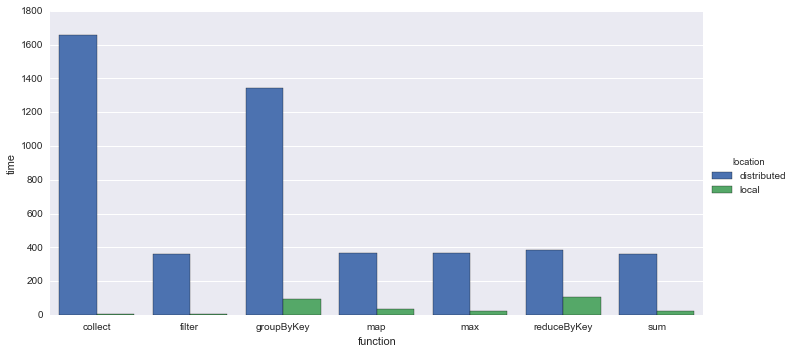

In [17]:
sns.factorplot("function", "time", "location", df, aspect=2.0);